In [1]:
import numpy as np
from scipy.special import lpmv
from scipy.integrate import simps
import matplotlib.pyplot as plt
from fftlog import fftlog

In [2]:
def xi2w_aniso(rp, pimax, k, L, pkL, m, N_extrap_high=512, N_extrap_low=512, N_pad=512):
    """
    Parameters
        rp  (array)        : perpendicular distance of galaxy pairs.
        pimax (float)      : maximum pi to integrate over
        k (array)          : input wave number
        L (list of int)    : the order of multipole
        pkL (list of array): power spectrum multipoles
        m (int)            : m value for associated Legendre polynomials, m=2 for IA.
        N_extrap_high (int): number of points for high-k extrapolation for fftlog
        N_extrap_low (int) : number of points for low-k extrapolation for fftlog
        N_pad (int)        : number of padding points for fftlog

    Returns
        w (array)          : projected correlation function
    """
    # Convert multipoles from Fourier to real space.
    # Inverse of Eq.(37) of https://arxiv.org/pdf/2202.11839
    xiL = []
    for pl, l in zip(pkL, L):
        f = fftlog(k, k**3*pl, N_extrap_high=N_extrap_low, N_extrap_low=N_extrap_high, N_pad=N_pad)
        r_fft, xil = f.fftlog(l)
        xil /= 2.0*np.pi**2
        xiL.append(xil * (1j)**l)

    # perform r_para (pi) integration
    pi= np.logspace(-3, np.log10(pimax), 300)
    r = np.sqrt(rp[None,:]**2+pi[:,None]**2)
    mu= pi[:,None]/r

    xi = 0
    for xil, l in zip(xiL, L):
        xi += np.interp(r, r_fft, xil) * lpmv(m, l, mu)
    w = 2*simps(xi, pi, axis=0)

    return w

In [3]:
# load an example set of power spectra
k, pk_lin, pk_nlin = np.loadtxt('./pk_P18.dat', unpack=True)

In [4]:
rp = np.logspace(0, 3.0, 301)
L = [0, 2]
# as a demo we just assume that P_0(k) = P_2(k) = P_{lin/nlin}(k)
%time w_lin = xi2w_aniso(rp, 100.0, k, L, [pk_lin , pk_lin] , 2)
%time w_nlin= xi2w_aniso(rp, 100.0, k, L, [pk_nlin, pk_nlin], 2)

CPU times: user 19.7 ms, sys: 4.73 ms, total: 24.4 ms
Wall time: 25.6 ms
CPU times: user 13.9 ms, sys: 570 µs, total: 14.5 ms
Wall time: 14.8 ms


/Users/sugiyamasunao/miniconda3/envs/csis3pcf/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/sugiyamasunao/miniconda3/envs/csis3pcf/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


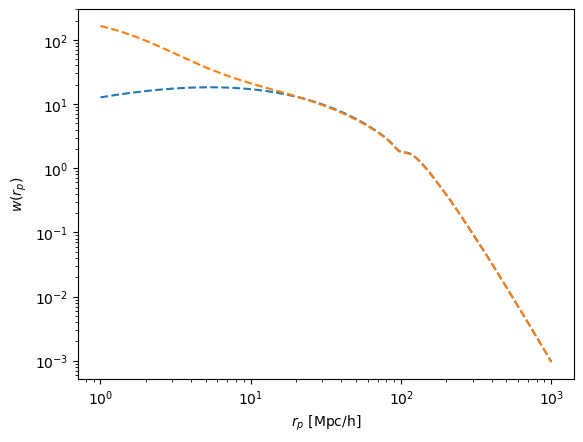

In [5]:
plt.loglog(rp, w_lin, 'C0-')
plt.loglog(rp,-w_lin, 'C0--')
plt.loglog(rp, w_nlin, 'C1-')
plt.loglog(rp,-w_nlin, 'C1--')
plt.xlabel(r'$r_p$ [Mpc/h]')
plt.ylabel(r'$w(r_p)$')
plt.show()